## initial configuration

In [1]:
import sys
from pathlib import Path
from importlib import reload

In [2]:
import platform
import sys
from pathlib import Path
from importlib import reload

os_name = platform.system()
if os_name == 'Darwin':
	gd_path = str(Path.home()/'Library/Mobile Documents/com~apple~CloudDocs/gd')
elif os_name == 'Linux':
	gd_path = str(Path.home()/'gd')
else:
	raise ValueError('You are not on either Darwin or Linux OS')

In [3]:
project_path = gd_path + '/projects'

sys.path.insert(0, project_path + '/ftnmr/scripts')
sys.path.insert(0, project_path + '/projnmr/scripts')
sys.path.insert(0, project_path + '/handson/scripts/part2')
sys.path.insert(0, project_path + '/mods/scripts')

In [4]:
import os
# for error "not creating xla devices tf_xla_enable_xla_devices not set"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#TF_XLA_FLAGS is an environment variable used by TensorFlow's XLA 
#compiler to control its behavior. In this case, setting TF_XLA_FLAGS to 
#--tf_xla_enable_xla_devices enables the XLA compiler to use all available 
# XLA devices, such as GPUs or TPUs, for faster execution of TF.

# for error "Successfully opened dynamic library libcudart.so.10.1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import ftnmr
import projnmr
import handson
import mods
import NN_models

from projnmr import metaboliteGenerator as mg
from string import ascii_letters as al
from functools import partial

In [6]:
import inspect
import random
import psutil
import gc

from functools import partial
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

import tensorflow as tf
from tensorflow import keras

In [7]:
# similar to os.environ['TF_XLA_FLAGS'], but preferred way to enable XLA
tf.config.optimizer.set_jit(True) 

tf.__version__ # TF version

'2.11.1'

In [8]:
devices = tf.config.get_visible_devices()
for dev in devices:
    print(dev.name)

/physical_device:CPU:0
/physical_device:XLA_CPU:0
/physical_device:GPU:0
/physical_device:XLA_GPU:0


In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
import pynvml
pynvml.nvmlInit()

gpus = pynvml.nvmlDeviceGetCount()
for i in range(gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU {i}: Total memory: {info.total / (1024**2)} MB")
    print(f"       Free memory: {info.free / (1024**2)} MB")

pynvml.nvmlShutdown()

GPU 0: Total memory: 16384.0 MB
       Free memory: 16106.5625 MB


In [11]:
# Get the Jupyter Lab process ID
jupyter_pid = !pgrep jupyter-lab
jupyter_pid = int(jupyter_pid[0])

# get memory usage of jupyter lab
process = psutil.Process(jupyter_pid)
memory_info = process.memory_info()
print(f"Jupyter Lab memory usage: {memory_info.rss/(1024**2)}MB")

Jupyter Lab memory usage: 183.41015625MB


## getting file paths

In [ ]:
# use the glob() method to find all HDF5 files in subdirectories of the current directory
hdf5_files = Path('.').glob('**/*.hdf5')

# transform PosixPath type into string type
hdf5_files = [str(file) for file in hdf5_files if 'baseline' in str(file)]
hdf5_files

In [ ]:
# split the datasets into train, valid, test
files_train = hdf5_files[:-2]
files_valid = hdf5_files[-2:-1]
files_test = hdf5_files[-1:]

files_train

In [ ]:
def data_generator(file_paths, num_samples=512, batch_size=64):
    np.random.shuffle(file_paths)
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            idx = np.random.permutation(num_samples)
            data = f['data'][:][idx]
            target = f['target'][:][idx]
            
            for i in range(0, num_samples, batch_size):
                data = f['data'][i:i+batch_size]
                target = f['target'][i:i+batch_size]
                yield f['data'][i:i+batch_size], f['target'][i:i+batch_size]

In [ ]:
input_shape = (2, 2)
kernel_size = (2, 2)
stride = 1
num_filters = 1

sqm = lambda n: np.expand_dims(np.arange(n**2).reshape(n, n), axis=-1)
lins = lambda n: np.array([np.expand_dims(np.linspace(0, n-1, n), axis=-1)])

In [ ]:
input_tensor = tf.constant([lins(4)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
input_tensor = tf.constant([sqm(3)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
kernel_weights = sqm(4)[:1, :, 0]
matd(kernel_weights)
print('kernel_weights')

In [ ]:
?keras.layers.Conv2DTranspose

In [ ]:
output_shape = (None, 3, 3, 1)

# Define the transposed Conv2D layer
tc2_layer = tf.keras.layers.Conv2DTranspose(
    filters=num_filters,
    kernel_size=kernel_weights.shape,
    strides=(1, 2),
    padding='valid',
    kernel_initializer=tf.constant_initializer(kernel_weights),
    #output_padding=
)

# Apply tc2_layer to the input tensor
output_tensor = tc2_layer(input_tensor)
matd(output_tensor[0][:, :, 0].numpy())

## spectrometer check

In [13]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

065.5k    0006.8    002.4k    0213.0

103.9μ    131.1k    018.3m    0054.5    0019.0    0003.0


In [16]:
spec = ftnmr.spectrometer(shift_maximum=128.0, shift_minimum=7)
spec.nf

32768

In [17]:
ru = np.random.uniform
rr = np.random.randint
moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, rr(1, 15))}
moles

{'A': (<ftnmr.molecule at 0x15520322d840>, 16.461746180420167),
 'B': (<ftnmr.molecule at 0x15520322e6b0>, 3.7989864570803613),
 'C': (<ftnmr.molecule at 0x15520322e200>, 43.348702937833785),
 'D': (<ftnmr.molecule at 0x15520322d6f0>, 27.169527424582064),
 'E': (<ftnmr.molecule at 0x15520322e3e0>, 2.233918117353867),
 'F': (<ftnmr.molecule at 0x15520322de40>, 20.512375754833133),
 'G': (<ftnmr.molecule at 0x15520322e800>, 4.944534224089497),
 'H': (<ftnmr.molecule at 0x1552b9002800>, 8.69449548583186),
 'I': (<ftnmr.molecule at 0x15520322e770>, 24.09568955321257),
 'J': (<ftnmr.molecule at 0x1552b90039d0>, 0.9889941980950279),
 'K': (<ftnmr.molecule at 0x15520322d870>, 21.72790017885725)}

In [18]:
spec.artifact(baseline=True)
spec.measure(moles=moles, extra_target=True)

## slicing NMR spectrum data check

In [27]:
dtype = 'float32'
data_length = 2**16
instance_size_in_bytes = np.dtype(dtype).itemsize*data_length
instance_size_in_bytes

262144

In [29]:
data_size_power = 10
number_of_measurements = int(2**(data_size_power+19)/instance_size_in_bytes)
number_of_measurements

2048

In [39]:
pwd

'/home/sejinnam/gd/projects/projnmr/scripts'

In [43]:
shift_path = Path.home() / 'data/NMR.SH8.data/chemical_shift.1390177.hdf5'
range = ftnmr.load_shift(shift_path)
range

array([0.0000000e+00, 4.8828125e-04, 9.7656250e-04, ..., 1.5998535e+01,
       1.5999023e+01, 1.5999512e+01], dtype=float32)

In [44]:
range.shape

(32768,)

In [45]:
num_samples = 1024
train_num = 16
data_length = 2**15
X = np.zeros((num_samples*train_num, data_length), dtype=dtype)

In [49]:
original_array = np.random.rand(16384, 32768)

# Step 1: Reshape to (16384, 8, 4096)
reshaped_array = original_array.reshape((16384, 8, 4096))

# Step 2: Reshape to (16384 * 8, 4096)
final_array = reshaped_array.reshape((16384 * 8, 4096))

final_array

array([[0.2757751 , 0.88153213, 0.35216377, ..., 0.85341977, 0.05940691,
        0.00906568],
       [0.50296326, 0.41705845, 0.61065479, ..., 0.17628186, 0.69436292,
        0.63517565],
       [0.69772744, 0.47907144, 0.3581568 , ..., 0.04652237, 0.22190355,
        0.73611134],
       ...,
       [0.12193628, 0.79630953, 0.72255891, ..., 0.6638547 , 0.69366145,
        0.41101247],
       [0.19145727, 0.60201315, 0.99887417, ..., 0.83117945, 0.16854019,
        0.86778235],
       [0.22200873, 0.81683317, 0.06706419, ..., 0.97971222, 0.67286926,
        0.95196777]])

In [72]:
hdf5_dir = Path.home() / 'data/NMR.data.two'
hdf5_dir

PosixPath('/home/sejinnam/data/NMR.data.two')

In [75]:
reload(ftnmr)

<module 'ftnmr' from '/home/sejinnam/gd/projects/ftnmr/scripts/ftnmr.py'>

In [77]:
tuples = ftnmr.sliced_spec_data2(hdf5_dir, numpy_array=True)
tuples

(array([[ 0.39263842,  0.38794133,  0.35508168, ...,  0.6772671 ,
          0.65150917,  0.6191709 ],
        [ 0.6033342 ,  0.60143626,  0.5966449 , ...,  0.63147545,
          0.64240015,  0.62475455],
        [ 0.60691166,  0.61568105,  0.6452844 , ...,  0.49211404,
          0.5140102 ,  0.50918955],
        ...,
        [ 0.06782454,  0.07567853,  0.0793468 , ...,  0.04228335,
          0.03902023,  0.03503347],
        [ 0.02693849,  0.0222165 ,  0.02626945, ..., -0.00110603,
          0.00443965,  0.01340785],
        [ 0.01248098,  0.00338998,  0.00237116, ...,  0.06232616,
          0.06353167,  0.03380632]], dtype=float32),
 array([[ 0.03708652,  0.03239022, -0.00046859, ...,  0.28105643,
          0.24773912,  0.20962812],
        [ 0.18970673,  0.1851723 ,  0.17890227, ...,  0.212201  ,
          0.22713755,  0.21358705],
        [ 0.19989534,  0.21283637,  0.24658512, ...,  0.00127743,
          0.02318908,  0.01838395],
        ...,
        [ 0.00925219,  0.0171048 ,  0.0

In [78]:
tuples[0].shape

(32768, 8192)

## Dynamic Data Generation

In [12]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

065.5k    0006.8    002.4k    0213.0

103.9μ    131.1k    018.3m    0054.5    0019.0    0003.0


In [59]:
ru = np.random.uniform
rr = np.random.randint
moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, rr(1, 15))}
moles

{'A': (<ftnmr.molecule at 0x145954205360>, 43.43669613035732),
 'B': (<ftnmr.molecule at 0x145954204af0>, 28.441549051071526),
 'C': (<ftnmr.molecule at 0x145954204b50>, 21.417144283391842),
 'D': (<ftnmr.molecule at 0x145954204d30>, 33.188468923809275),
 'E': (<ftnmr.molecule at 0x145954205960>, 41.56452161435665),
 'F': (<ftnmr.molecule at 0x145954204a30>, 49.27772808625096),
 'G': (<ftnmr.molecule at 0x1459542057e0>, 11.930166396065239)}

In [62]:
spec.artifact(baseline=True)
spec.measure(moles=moles, extra_target=True)

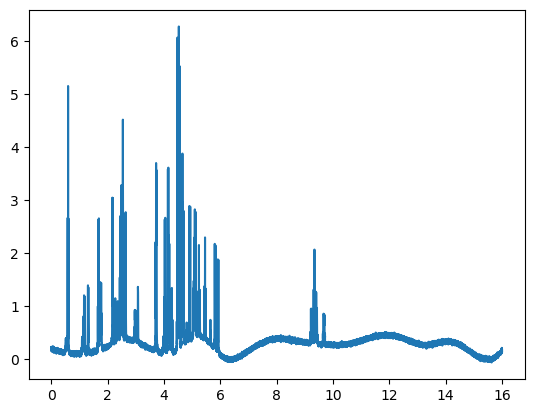

In [64]:
plt.plot(spec.shift, spec.spectra)
plt.show()

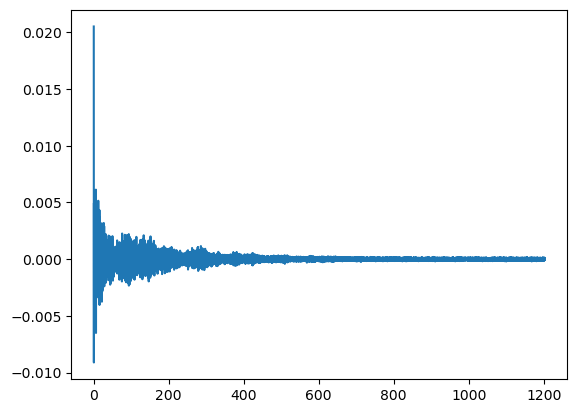

In [65]:
plt.plot(spec.t[:spec.nf], spec.signal.real[:spec.nf])
plt.show()

In [67]:
input_size = 2**10
print(f"input size: {input_size}")
rescale_ratio = int(spec.nf/input_size)
target = np.reshape(spec.target, (input_size, rescale_ratio))
target2 = np.reshape(spec.target2, (input_size, rescale_ratio))
spectra = np.reshape(spec.spectra, (input_size, rescale_ratio))

max_target = np.max(target, axis=1)
mean_target = np.mean(target, axis=1)
max_target2 = np.max(target2, axis=1)
mean_target2 = np.mean(target2, axis=1)
max_spectra = np.max(spectra, axis=1)
mean_spectra = np.mean(spectra, axis=1)

rescaled_shift = spec.shift[::rescale_ratio]

input size: 1024


In [69]:
max_target2

array([0.03871577, 0.0443976 , 0.07105373, ..., 0.05422848, 0.05706055,
       0.04336172], dtype=float32)

In [70]:
max_target

array([0.04645316, 0.04661874, 0.05261057, ..., 0.04181544, 0.053975  ,
       0.06769958], dtype=float32)

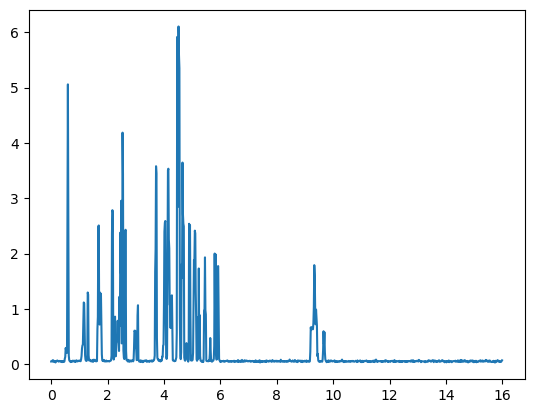

In [72]:
plt.plot(rescaled_shift, max_target)
plt.show()

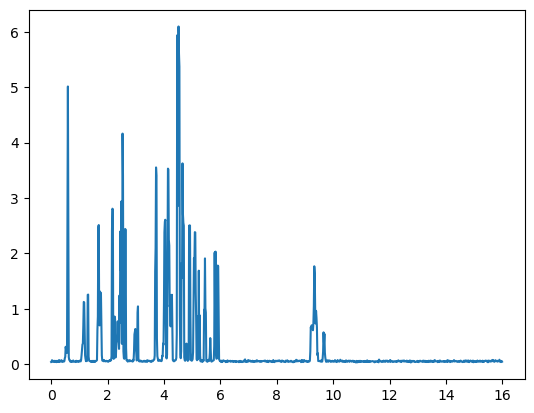

In [71]:
plt.plot(rescaled_shift, max_target2)
plt.show()

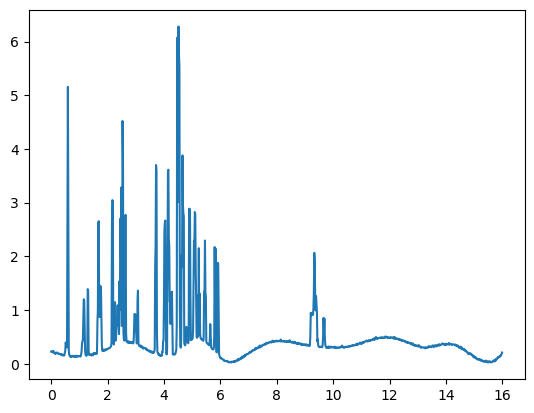

In [73]:
plt.plot(rescaled_shift, max_spectra)
plt.show()

In [79]:
spec()

(array([0.21940625, 0.22487774, 0.20438164, ..., 0.14676362, 0.13862   ,
        0.14151873], dtype=float32),
 array([ 0.03940476,  0.04492171,  0.02447106, ...,  0.00187016,
        -0.00644932, -0.00372657], dtype=float32),
 array([ 0.00957974,  0.03380265,  0.03587672, ...,  0.00833279,
        -0.01300592,  0.00433048], dtype=float32))

## Phase Shift artifact

In [133]:
## initialize spectrometer with random number of molecules
spec = ftnmr.spectrometer(shift_maximum=128.0)
num_of_moles = np.random.randint(1, 15)
input_size = 2**10

# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=False
phase_shift=True
smoothness=False
moles = {al[26+k]:(mg(), np.random.uniform(0, 50)) for k in range(0, num_of_moles)}

# set artifact and measure the signal
spec.artifact(baseline=baseline, phase_shift=phase_shift, smoothness=smoothness)
spec.measure(moles=moles)
input_size = 2**10

In [134]:
max_spectra, max_target, rescaled_shift = ftnmr.max_reduction(spec, input_size)

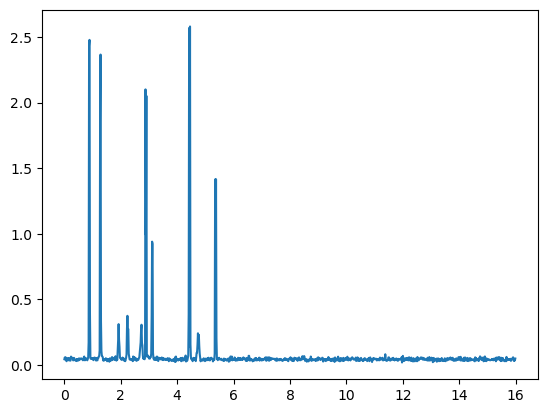

In [135]:
plt.plot(rescaled_shift, max_target)
plt.show()

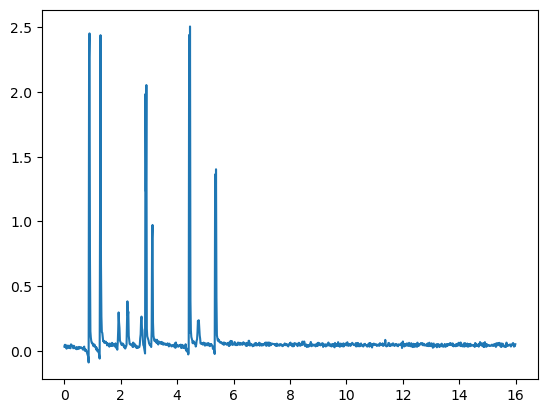

In [136]:
plt.plot(rescaled_shift, max_spectra)
plt.show()

In [120]:
64*20

1280

## Data Generator

In [80]:
# initialize spectrometer with random number of molecules
spec = ftnmr.spectrometer(shift_maximum=128.0)
num_of_moles = np.random.randint(1, 15)

# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=True
phase_shift=False
smoothness=False
moles = {al[26+k]:(mg(), np.random.uniform(0, 50)) for k in range(0, num_of_moles)}

# set artifact and measure the signal
spec.artifact(baseline=baseline, phase_shift=phase_shift, smoothness=smoothness)
spec.measure(moles=moles)

# sample output
output = spec()
output

(array([0.22286393, 0.21535394, 0.22055787, ..., 0.1459843 , 0.13912012,
        0.13936812], dtype=float32),
 array([0.00871326, 0.00871332, 0.00871334, ..., 0.00848973, 0.00848981,
        0.00848982], dtype=float32))

In [56]:
# data generator internal parameters
spec = ftnmr.spectrometer(shift_maximum=128.0)
input_size = 2**10
rescale_ratio = int(spec.nf/input_size)

def data_generator(baseline, phase_shift, smoothness):
    while True:
        # get number of different types of molecules
        rr = np.random.randint
        ru = np.random.uniform
        num_of_moles = rr(1, 15)
        moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, num_of_moles)}
    
        # measure the signal with artifact
        spec.artifact(
            baseline=baseline, 
            phase_shift=phase_shift, 
            smoothness=smoothness)
        spec.measure(moles=moles)
    
        # reshape the output for memory management using reshape and max (or mean)
        spectra = np.reshape(spec.spectra, (input_size, rescale_ratio))
        target = np.reshape(spec.target, (input_size, rescale_ratio))
        max_spectra = np.max(spectra, axis=1) # max or mean
        max_target = np.max(target, axis=1) # max or mean
    
        yield max_spectra, max_target

In [57]:
# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=True
phase_shift=False
smoothness=False

args = [baseline, phase_shift, smoothness]
args = tuple(tf.constant(x) for x in args)
display(args)

data_gen_output = data_generator(baseline, phase_shift, smoothness)
data_gen_output

(<tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 <tf.Tensor: shape=(), dtype=bool, numpy=False>)

<generator object data_generator at 0x154c1c14eb90>

In [73]:
# dataset from generator
size = input_size
batch_size = 8

dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

display(dataset)

first_output = next(iter(dataset))
first_output

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))>

(<tf.Tensor: shape=(8, 1024), dtype=float32, numpy=
 array([[45.098835, 45.108315, 45.050026, ..., 45.000366, 44.93574 ,
         44.8526  ],
        [45.473305, 45.439533, 45.429012, ..., 45.154842, 45.08999 ,
         45.028805],
        [45.564228, 45.557816, 45.514633, ..., 45.220005, 45.143497,
         45.077328],
        ...,
        [46.017487, 45.94809 , 45.92479 , ..., 45.571323, 45.512283,
         45.423103],
        [46.264072, 46.23345 , 46.16962 , ..., 45.653385, 45.58164 ,
         45.501972],
        [46.400356, 46.336567, 46.299034, ..., 45.8601  , 45.80394 ,
         45.72599 ]], dtype=float32)>,
 <tf.Tensor: shape=(8, 1024), dtype=float32, numpy=
 array([[0.01058638, 0.01059614, 0.01060649, ..., 0.01027915, 0.01027913,
         0.01027912],
        [0.00131609, 0.00131823, 0.00132052, ..., 0.00126396, 0.00126396,
         0.00126396],
        [0.01311748, 0.0131321 , 0.01314764, ..., 0.01271258, 0.01271256,
         0.01271254],
        ...,
        [0.01516165, 0.0

### from generator to data

In [71]:
def data_from_generator(generator, num_val_power, batch_size_power):
    """
    The generator must return both target and label data
    """
    assert_info = "batch_size_power is greater than num_val_power"
    assert batch_size_power < num_val_power, assert_info

    # number of validation+train dataset and sample data, batch size
    num_val = 2**num_val_power
    num_tra = 8*num_val
    sample_target, sample_label = next(iter(generator))
    batch_size = 2**batch_size_power

    # shapes for output tensors
    train_target_shape = (num_tra, *sample_target.shape)
    train_label_shape = (num_tra, *sample_label.shape)
    valid_target_shape = (num_val, *sample_target.shape)
    valid_label_shape = (num_val, *sample_label.shape)

    # preallocate output tensors
    target_tra = np.zeros(train_target_shape, dtype=sample_target.dtype)
    label_tra = np.zeros(train_label_shape, dtype=sample_label.dtype)
    target_val = np.zeros(valid_target_shape, dtype=sample_target.dtype)
    label_val = np.zeros(valid_label_shape, dtype=sample_label.dtype)

    # target dataset
    for index, data in zip(range(num_tra), generator):
        target_tra[index], label_tra[index] = data
        
    # validation dataset
    for index, data in zip(range(num_val), generator):
        target_val[index], label_val[index] = data

    # obtain tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, label_tra))
    train_dataset = train_dataset.batch(batch_size)
    valid_dataset = tf.data.Dataset.from_tensor_slices((target_val, label_val))
    valid_dataset = test_dataset.batch(batch_size)

    return train_dataset, valid_dataset

In [66]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

065.5k    0006.8    002.4k    0213.0

103.9μ    131.1k    018.3m    0054.5    0019.0    0003.0


## Testing Model

In [36]:
data_dir = Path.home() / Path('data/NMR.data/data.918708/')
datasets = ftnmr.load_spec_data(data_dir, batch_size=128, numpy_array=False)
data_shape = next(iter(datasets[0]))[0].shape
display(data_shape)

TensorShape([128, 1024])

In [37]:
dataset_train = datasets[0]
dataset_valid = datasets[1]
dataset_test = datasets[2]

### recurrent NN structures in multiple cells

In [38]:
# configuration
input_length = data_shape[1]
expand_layer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
GRU_unit = 16
first_filter_num = 128
transpose_layer = keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 1, 3, 2]))
second_filter_num = 64

In [39]:
# seq_input = keras.layers.Input(shape=[input_length])
seq_input = keras.layers.Input(shape=[None])

seq_input

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_1')>

In [40]:
expand_output = expand_layer(seq_input)
expand_output

<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'lambda_4')>

In [41]:
#skip
pool_output = keras.layers.MaxPool1D(pool_size)(expand_output)
pool_output

NameError: name 'pool_size' is not defined

In [42]:
GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)
GRU_output

<KerasTensor: shape=(None, None, 32) dtype=float32 (created by layer 'bidirectional')>

In [43]:
expand_output2 = expand_layer(GRU_output)
expand_output2

<KerasTensor: shape=(None, None, 32, 1) dtype=float32 (created by layer 'lambda_4')>

In [44]:
cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu')
cnn_output1 = cnn_layer1(expand_output2)
cnn_output1

<KerasTensor: shape=(None, None, 1, 128) dtype=float32 (created by layer 'conv2d')>

In [45]:
transpose_output = transpose_layer(cnn_output1)
transpose_output

<KerasTensor: shape=(None, None, 128, 1) dtype=float32 (created by layer 'lambda_5')>

In [46]:
cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu')
cnn2_output = cnn_layer2(transpose_output)
cnn2_output

<KerasTensor: shape=(None, None, 1, 64) dtype=float32 (created by layer 'conv2d_1')>

In [47]:
transpose2_output = transpose_layer(cnn2_output)
transpose2_output

<KerasTensor: shape=(None, None, 64, 1) dtype=float32 (created by layer 'lambda_5')>

In [48]:
cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='selu')
cnn3_output = cnn_layer3(transpose2_output)
cnn3_output

<KerasTensor: shape=(None, None, 1, 1) dtype=float32 (created by layer 'conv2d_2')>

In [49]:
#skip
upscale_output = keras.layers.UpSampling2D(
    size=(pool_size, 1), 
    interpolation='bicubic')(cnn3_output)
upscale_output

NameError: name 'pool_size' is not defined

In [50]:
flat_output = keras.layers.Flatten()(cnn3_output)
flat_output

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'flatten')>

In [51]:
model_output = keras.layers.Add()([seq_input, flat_output])
model_output

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'add')>

In [52]:
expand_output

<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'lambda_4')>

### continue...

In [38]:
# configuration
input_length = data_shape[1]
expand_layer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
GRU_unit = 16
first_filter_num = 128
transpose_layer = keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 1, 3, 2]))
second_filter_num = 64

# same as above execution of cells, but all the cells are merged
seq_input = keras.layers.Input(shape=[input_length])

expand_output = expand_layer(seq_input)

GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)

expand_output2 = expand_layer(GRU_output)

cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu') # elu
cnn_output1 = cnn_layer1(expand_output2)

transpose_output = transpose_layer(cnn_output1)

cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu') # selu
cnn2_output = cnn_layer2(transpose_output)

transpose2_output = transpose_layer(cnn2_output)

cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='LeakyReLU') # selu
cnn3_output = cnn_layer3(transpose2_output)

flat_output = keras.layers.Flatten()(cnn3_output)

model_output = keras.layers.Add()([seq_input, flat_output])

### continue...

In [53]:
model = keras.Model(inputs=[seq_input], outputs=[model_output])

In [54]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [55]:
model.compile(
    loss="mse", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.0005),
    metrics=['mse'])

In [56]:
history = model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=128,
    callbacks=[early_stopping])

Epoch 1/128
  68/1024 [>.............................] - ETA: 43s - loss: 0.0108 - mse: 0.0108

KeyboardInterrupt: 

In [48]:
history2 = model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=64,
    callbacks=[early_stopping])

Epoch 1/64
1024/1024 [==============================] - 60s 58ms/step - loss: 8.7084e-06 - mse: 8.7084e-06 - val_loss: 8.2441e-06 - val_mse: 8.2441e-06
Epoch 2/64
1024/1024 [==============================] - 59s 57ms/step - loss: 8.5998e-06 - mse: 8.5998e-06 - val_loss: 8.5726e-06 - val_mse: 8.5726e-06
Epoch 3/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.6595e-06 - mse: 8.6595e-06 - val_loss: 7.8934e-06 - val_mse: 7.8934e-06
Epoch 4/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.5906e-06 - mse: 8.5906e-06 - val_loss: 7.7789e-06 - val_mse: 7.7789e-06
Epoch 5/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.5088e-06 - mse: 8.5088e-06 - val_loss: 1.1517e-05 - val_mse: 1.1517e-05
Epoch 6/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.4502e-06 - mse: 8.4502e-06 - val_loss: 7.7347e-06 - val_mse: 7.7347e-06
Epoch 7/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.4850e-06

In [49]:
print(history2.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [50]:
for key in history2.history.keys():
    with open('baseline2_' + key + '.npy', 'wb') as f:
        np.save(f, np.array(historys.history[key]).astype('float32'))

In [27]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

In [59]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 14ms/step


In [29]:
spec = ftnmr.spectrometer(shift_maximum=128.0)
input_size = 2**10
rescale_ratio = int(spec.nf/input_size)
rescaled_shift = spec.shift[::rescale_ratio]

In [71]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

58


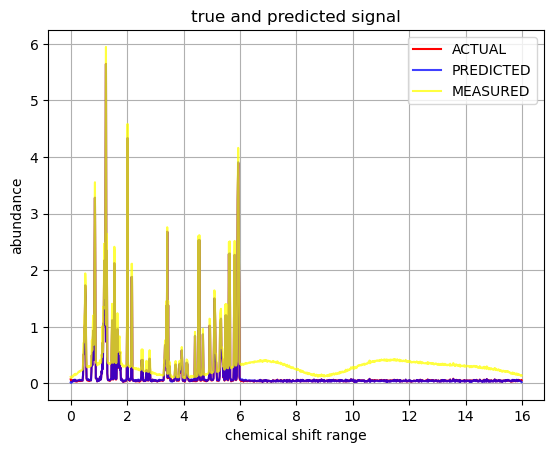

In [72]:
# TRUE plot
plt.plot(rescaled_shift, y_true, label='ACTUAL', color='red')

# PREDICTED plot
plt.plot(rescaled_shift, y_p, label='PREDICTED', color='blue', alpha=0.75)

# MEASURED plot
plt.plot(rescaled_shift, x_t, label='MEASURED', color='yellow', alpha=0.75)

# Set the labels and title
plt.xlabel('chemical shift range')
plt.ylabel('abundance')
plt.title('true and predicted signal')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [52]:
model.save('model_baseline.feb.16.2024.hdf5')

## loading baseline model

In [93]:
loaded_model_baseline = keras.models.load_model(
    'prototype.feb.16.2024.hdf5', 
    compile=False)

In [94]:
data_dir = Path.home() / Path('metric.data/baseline/data.1290465/')
datasets = ftnmr.load_spec_data(data_dir, batch_size=128, numpy_array=False)
data_shape = next(iter(datasets[0]))[0].shape
display(data_shape)

dataset_train = datasets[0]
dataset_valid = datasets[1]
dataset_test = datasets[2]

X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

TensorShape([128, 1024])

In [100]:
y_pred = loaded_model_baseline.predict(X_test)
range_path = Path.home() / Path('metric.data/baseline/chemical_shift.1290465.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]

4/4 [==============================] - 0s 27ms/step


In [101]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

40


Output()

## phase shift model

In [81]:
phase_data_dir = Path.home() / Path('NMR.data/data.918707/')
phase_datasets = ftnmr.load_spec_data(
    phase_data_dir, 
    batch_size=128, 
    numpy_array=False)
data_shape = next(iter(phase_datasets[0]))[0].shape
display(data_shape)

TensorShape([128, 1024])

In [82]:
dataset_train = phase_datasets[0]
dataset_valid = phase_datasets[1]
dataset_test = phase_datasets[2]

In [102]:
input_length = data_shape[1]
GRU_unit = 16
first_filter_num = 128
second_filter_num = 64

In [104]:
model_phase = NN_models.model_NMR(
    input_length, 
    GRU_unit, 
    first_filter_num, 
    second_filter_num)

In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [106]:
model_phase.compile(
    loss="mse", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.005),
    metrics=['mse'])

In [107]:
history = model_phase.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16
1024/1024 [==============================] - 64s 56ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 2/16
1024/1024 [==============================] - 58s 56ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.8941e-04 - val_mse: 8.8941e-04
Epoch 3/16
1024/1024 [==============================] - 59s 57ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 8.5669e-04 - val_mse: 8.5669e-04
Epoch 4/16
1024/1024 [==============================] - 56s 55ms/step - loss: 8.3056e-04 - mse: 8.3056e-04 - val_loss: 7.8516e-04 - val_mse: 7.8516e-04
Epoch 5/16
1024/1024 [==============================] - 59s 58ms/step - loss: 7.8545e-04 - mse: 7.8545e-04 - val_loss: 7.3079e-04 - val_mse: 7.3079e-04
Epoch 6/16
1024/1024 [==============================] - 56s 55ms/step - loss: 7.4980e-04 - mse: 7.4980e-04 - val_loss: 8.1481e-04 - val_mse: 8.1481e-04
Epoch 7/16
1024/1024 [==============================] - 57s 56ms/step - loss: 7.1836e-04 - mse: 7.1836e-04 - val_loss: 6

In [108]:
model_phase.save('model_phase.feb.05.2024.hdf5')

In [109]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

In [17]:
range_path = Path.home() / Path('NMR.data/chemical_shift.918707.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]

In [22]:
y_pred = model_phase.predict(X_test)

NameError: name 'model_phase' is not defined

In [159]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

42


In [125]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

30


Output()

## phase shift and baseline model

In [34]:
PHB_data_dir = Path.home() / Path('NMR.data/data.918710/')
PHB_datasets = ftnmr.load_spec_data(
    PHB_data_dir, 
    batch_size=128, 
    numpy_array=False)
data_shape = next(iter(PHB_datasets[0]))[0].shape
display(data_shape)

2024-02-18 01:15:26.069563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:98:00.0, compute capability: 8.0


TensorShape([128, 1024])

In [35]:
dataset_train = PHB_datasets[0]
dataset_valid = PHB_datasets[1]
dataset_test = PHB_datasets[2]

In [20]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

range_path = Path.home() / Path('NMR.data/chemical_shift.918710.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]
    
ind = np.random.choice(range(len(y_test)))
x_t = X_test[ind]
y_true = y_test[ind]
print(ind)

Y = [x_t, y_true]
Y_names = ['MEASURE', 'ACTUAL'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

51


Output()

In [21]:
input_length = data_shape[1]
GRU_unit = 32
first_filter_num = 128
second_filter_num = 64

In [59]:
model_PHB = NN_models.model_NMR(
    input_length, 
    GRU_unit, 
    first_filter_num, 
    second_filter_num)

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [75]:
model_PHB.compile(
    loss="LogCosh", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.005, clipvalue=1.0),
    metrics=['mse'])

In [76]:
history = model_PHB.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16
1024/1024 [==============================] - 62s 56ms/step - loss: 7.0613e-04 - mse: 0.0015 - val_loss: 6.9278e-04 - val_mse: 0.0014
Epoch 2/16
1024/1024 [==============================] - 61s 60ms/step - loss: 6.0042e-04 - mse: 0.0012 - val_loss: 6.8235e-04 - val_mse: 0.0014
Epoch 3/16
1024/1024 [==============================] - 57s 56ms/step - loss: 5.5091e-04 - mse: 0.0011 - val_loss: 5.7657e-04 - val_mse: 0.0012
Epoch 4/16
1024/1024 [==============================] - 61s 60ms/step - loss: 5.1395e-04 - mse: 0.0011 - val_loss: 6.2274e-04 - val_mse: 0.0013
Epoch 5/16
1024/1024 [==============================] - 65s 63ms/step - loss: 4.8192e-04 - mse: 9.8657e-04 - val_loss: 4.8553e-04 - val_mse: 9.9155e-04
Epoch 6/16
1024/1024 [==============================] - 65s 63ms/step - loss: 4.6039e-04 - mse: 9.4217e-04 - val_loss: 4.2490e-04 - val_mse: 8.6869e-04
Epoch 7/16
1024/1024 [==============================] - 64s 63ms/step - loss: 0.0035 - mse: 0.0085 - val_loss: 8.9297e-0

In [77]:
model_PHB.save('model_PHB.feb.06.2024.hdf5')

In [78]:
y_pred = model_PHB.predict(X_test)

4/4 [==============================] - 1s 23ms/step


In [81]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

48


Output()

## Large Sequence Length Testing *

In [12]:
data_dir = Path.home() / Path('data/NMR.SH8.data/data.1390177')
PHB_datasets = ftnmr.sliced_spec_data(data_dir, batch_size=64, numpy_array=False)
data_shape = next(iter(PHB_datasets[0]))[0].shape
display(data_shape)

2024-03-01 18:18:54.708766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:8c:00.0, compute capability: 7.5


TensorShape([64, 4096])

In [40]:
len(PHB_datasets)

3

In [45]:
first_X_batch, first_y_batch = next(iter(PHB_datasets[0]))
first_X = first_X_batch.numpy()
first_y = first_y_batch.numpy()

first_X

array([[ 0.1789454 ,  0.19545965,  0.20421286, ...,  0.46035662,
         0.44895184,  0.4118185 ],
       [ 0.09289137,  0.10753782,  0.10515983, ...,  0.4386627 ,
         0.4213422 ,  0.41363811],
       [ 0.3434996 ,  0.34097913,  0.35041744, ...,  0.31319937,
         0.2955315 ,  0.30323514],
       ...,
       [ 0.46530288,  0.43665427,  0.42735144, ...,  2.182758  ,
         2.337721  ,  2.4819107 ],
       [ 0.24614918,  0.25568533,  0.27260545, ...,  0.09302053,
         0.11646878,  0.13491324],
       [-0.02456891, -0.01470544,  0.03199461, ...,  0.07325768,
         0.12533557,  0.20253871]], dtype=float32)

In [18]:
shift_path = Path.home() / Path('data/NMR.SH8.data/chemical_shift.1390177.hdf5')
shift = ftnmr.load_shift(shift_path)
shift

array([0.0000000e+00, 4.8828125e-04, 9.7656250e-04, ..., 1.5998535e+01,
       1.5999023e+01, 1.5999512e+01], dtype=float32)

In [37]:
SH.shape

(4096,)

In [58]:
n = 55
SH = shift[:4096]

X = first_X[n]
y_true = first_y[n]
Y = [X, y_true]
Y_names = ['MEASURE', 'ACTUAL'] 
mods.interactive_graph(SH, Y, Y_names=Y_names)

Output()

In [59]:
dataset_train = PHB_datasets[0]
dataset_valid = PHB_datasets[1]
dataset_test = PHB_datasets[2]

In [60]:
input_length = None
GRU_unit = 32
first_filter_num = 128
second_filter_num = 64

In [61]:
model_PHB = NN_models.model_NMR(
    input_length, 
    GRU_unit, 
    first_filter_num, 
    second_filter_num)

In [119]:
# Monitor validation loss (or any relevant metric)
weight_path = "model_PHB_AIL.mar.01.2024.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        weight_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min')

In [120]:
tf.keras.callbacks.ModelCheckpoint?

Init signature:
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor: str = 'val_loss',
    verbose: int = 0,
    save_best_only: bool = False,
    save_weights_only: bool = False,
    mode: str = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
    **kwargs,
)
Docstring:     
Callback to save the Keras model or model weights at some frequency.

`ModelCheckpoint` callback is used in conjunction with training using
`model.fit()` to save a model or weights (in a checkpoint file) at some
interval, so the model or weights can be loaded later to continue the
training from the state saved.

A few options this callback provides include:

- Whether to only keep the model that has achieved the "best performance" so
  far, or whether to save the model at the end of every epoch regardless of
  performance.
- Definition of 'best'; which quantity to monitor and whether it should be
  maximized or minimized.
- The frequency it should save at. Currently, the

In [62]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [63]:
model_PHB.compile(
    loss="LogCosh", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.005, clipvalue=1.0),
    metrics=['mse'])

In [64]:
history = model_PHB.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16


2024-03-01 18:53:22.901247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


2048/2048 [==============================] - 371s 174ms/step - loss: 0.0023 - mse: 0.0047 - val_loss: 7.9674e-04 - val_mse: 0.0016
Epoch 2/16
2048/2048 [==============================] - 353s 173ms/step - loss: 6.4838e-04 - mse: 0.0013 - val_loss: 4.2217e-04 - val_mse: 8.5317e-04
Epoch 3/16
2048/2048 [==============================] - 354s 173ms/step - loss: 0.0021 - mse: 0.0049 - val_loss: 5.4867e-04 - val_mse: 0.0011
Epoch 4/16
2048/2048 [==============================] - 351s 172ms/step - loss: 4.9429e-04 - mse: 9.9817e-04 - val_loss: 2.8659e-04 - val_mse: 5.7872e-04
Epoch 5/16
2048/2048 [==============================] - 351s 172ms/step - loss: 3.8439e-04 - mse: 7.7402e-04 - val_loss: 3.0150e-04 - val_mse: 6.0643e-04
Epoch 6/16
2048/2048 [==============================] - 353s 172ms/step - loss: 0.0020 - mse: 0.0042 - val_loss: 0.0019 - val_mse: 0.0040
Epoch 7/16
2048/2048 [==============================] - 353s 172ms/step - loss: 0.0016 - mse: 0.0033 - val_loss: 0.0011 - val_mse: 

In [65]:
model_PHB.save('model_PHB_AIL.mar.01.2024.hdf5')

In [66]:
shift_path = Path.home() / Path('data/Large.NMR.data/chemical_shift.1383741.hdf5')
shift = ftnmr.load_shift(shift_path)
shift

array([0.0000000e+00, 2.4414062e-04, 4.8828125e-04, ..., 1.5999268e+01,
       1.5999512e+01, 1.5999756e+01], dtype=float32)

In [67]:
loaded_model_PHB = keras.models.load_model(
    'model_PHB_AIL.mar.01.2024.hdf5', 
    compile=False)

In [68]:
data_path = Path.home() / Path('data/Large.NMR.data/data.1383741a/baseline00.hdf5')
dataset = ftnmr.HDF5_load(data_path, numpy_array=True)

In [69]:
dataset[0].shape

(2048, 65536)

In [70]:
n = 128 # number of samples to infer
X = dataset[0][:n]
y = dataset[1][:n]

In [71]:
y_pred = loaded_model_PHB.predict(X)

4/4 [==============================] - 7s 1s/step


In [72]:
y_pred.shape

(128, 65536)

In [123]:
ind = np.random.choice(range(len(y_pred)))
x_t = X[ind]
y_true = y[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(shift, Y, Y_names=Y_names)

12


Output()

In [115]:
# save history content
history_hdf5_path = str(data_dir.parent / 'history.mar.03.2024.hdf5')
ftnmr.save_history(history, history_hdf5_path)

In [ ]:
PHB_data_dir = Path.home() / Path('data/Large.NMR.data/data.1383741a/')
PHB_datasets = ftnmr.load_spec_data(
    PHB_data_dir, 
    batch_size=128, 
    numpy_array=False)
data_shape = next(iter(PHB_datasets[0]))[0].shape
display(data_shape)

In [ ]:
X = next(iter(dataset_test))[0].numpy()
y = next(iter(dataset_test))[1].numpy()

In [81]:
data_path = Path.home() / Path('data/Large.NMR.data/data.1383741/baseline00.hdf5')
dataset = ftnmr.HDF5_load(data_path)

X = next(iter(dataset_test))[0].numpy()
y = next(iter(dataset_test))[1].numpy()

In [27]:
y_pred = loaded_model_PHB.predict(X)

2024-02-28 21:46:29.697328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


4/4 [==============================] - 4s 18ms/step


In [32]:
X.shape

(128, 1024)

## Metrics

In [23]:
baseline_data_dir = Path.home() / Path('data/metric.data/baseline/data.1290465/')
baseline_datasets = ftnmr.load_spec_data(
    baseline_data_dir, 
    batch_size=128, 
    numpy_array=True,
    extra_target=True)

phase_data_dir = Path.home() / Path('data/metric.data/phase_shift/data.1290570/')
phase_datasets = ftnmr.load_spec_data(
    phase_data_dir, 
    batch_size=128, 
    numpy_array=True,
    extra_target=True)

comb_data_dir = Path.home() / Path('data/metric.data/combined/data.1290575/')
comb_datasets = ftnmr.load_spec_data(
    comb_data_dir, 
    batch_size=128, 
    numpy_array=True,
    extra_target=True)

In [24]:
len(baseline_datasets) # be careful, feature and target are separated

9

In [26]:
def metric_RMSE(array1, array2):
    rmse = np.sqrt( np.average( (array1 - array2)**2 , axis=1) )
    mean = np.average(rmse)
    std = np.std(rmse)/len(rmse)
    return mean, std

In [27]:
# baseline
loaded_model_baseline = keras.models.load_model(
    'model_baseline.jan.23.2024.hdf5', 
    compile=False)

In [28]:
base_input, base_target, base_target2 = baseline_datasets[:3]
base_target2.shape

(4096, 1024)

In [32]:
y_pred = loaded_model_baseline.predict(base_input)
range_path = Path.home() / Path('data/metric.data/baseline/chemical_shift.1290465.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]

128/128 [==============================] - 2s 17ms/step


In [33]:
ind = np.random.choice(range(len(y_pred)))
x_t = base_input[ind]
y_true = base_target[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

1621


Output()

In [34]:
# model performance
mean, SDM = metric_RMSE(y_pred, base_target)
mean, SDM

(0.0068309577, 5.88198702189402e-07)

In [35]:
mods.print_formatted(mean, SDM, 213)

006.8m    588.2n    0213.0


In [36]:
# no correct at all 
metric_RMSE(base_input, base_target)

(0.16927394, 2.032632073678542e-05)

In [37]:
# noise error 
metric_RMSE(base_target, base_target2)

(0.014299634, 2.52645975251653e-07)

In [38]:
diff1 = y_pred - base_target
residuals1 = np.average(diff1, axis=0)

start = 32
end = 384

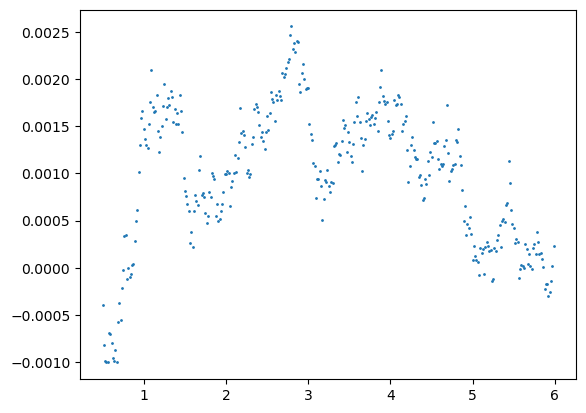

In [39]:
plt.scatter(chemical_shift[start:end], residuals1[start:end], s=1)
plt.show()

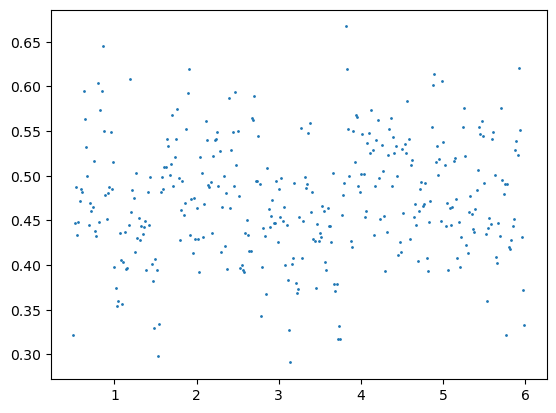

In [40]:
dist1 = np.average(base_target, axis=0)

plt.scatter(chemical_shift[start:end], dist1[start:end], s=1)
plt.show()

In [41]:
# phase shift
loaded_model_phase = keras.models.load_model(
    'model_phase.feb.05.2024.hdf5', 
    compile=False)

In [69]:
phase_input, phase_target, phase_target2 = phase_datasets[:3]
phase_target2.shape 

(4096, 1024)

In [70]:
y_pred2 = loaded_model_phase.predict(phase_input)

128/128 [==============================] - 7s 55ms/step


In [71]:
# ind = np.random.choice(range(len(y_pred2)))
ind = 636
x_t = phase_input[ind]
y_true = phase_target[ind]
y_p = y_pred2[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

636


Output()

In [72]:
# model performance
metric_RMSE(y_pred2, phase_target)

(0.01813978, 4.405325398693094e-06)

In [73]:
# no correction at all 
metric_RMSE(phase_input, base_target)

(0.83022517, 5.9627836890285835e-05)

In [74]:
# noise error 
metric_RMSE(phase_target, phase_target2)

(0.014336627, 2.3809984384115523e-07)

In [92]:
diff2 = y_pred2 - base_target
residuals2 = np.average(diff2, axis=0)

start = 32
end = 384

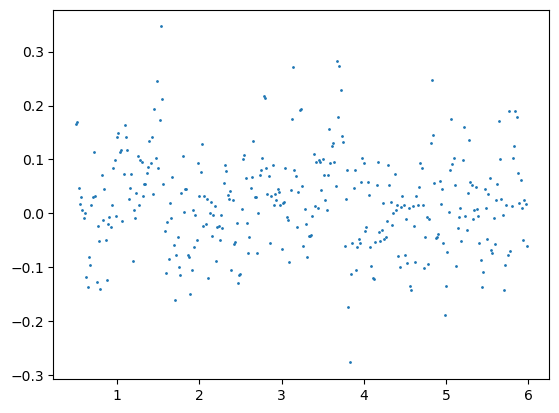

In [93]:
plt.scatter(chemical_shift[start:end], residuals2[start:end], s=1)
plt.show()

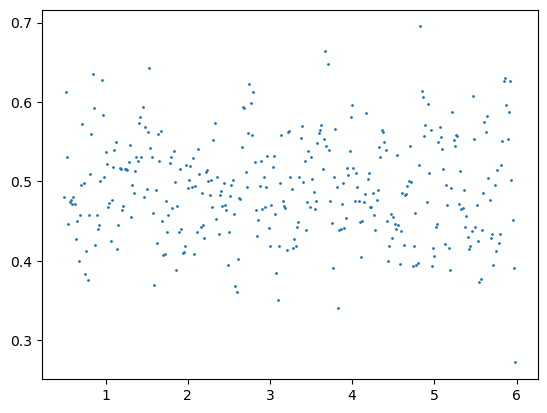

In [81]:
dist2 = np.average(phase_target, axis=0)

plt.scatter(chemical_shift[start:end], dist2[start:end], s=1)
plt.show()

In [42]:
# phase shift + baseline
loaded_model_PHB = keras.models.load_model(
    'model_PHB.feb.06.2024.hdf5', 
    compile=False)

In [43]:
comb_input, comb_target, comb_target2 = comb_datasets[:3]
comb_target2.shape 

(4096, 1024)

In [44]:
y_pred3 = loaded_model_PHB.predict(comb_input)

128/128 [==============================] - 3s 17ms/step


In [45]:
ind = np.random.choice(range(len(y_pred3)))
x_t = comb_input[ind]
y_true = comb_target[ind]
y_p = y_pred3[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

2418


Output()

In [46]:
# model performance
metric_RMSE(y_pred3, comb_target)

(0.02282173, 4.051054474984994e-06)

In [47]:
# no correction at all 
metric_RMSE(comb_input, comb_target)

(0.17493846, 1.9971099391113967e-05)

In [48]:
# noise error 
metric_RMSE(comb_target, comb_target2)

(0.01431758, 2.4829677158777486e-07)

In [49]:
diff3 = y_pred3 - comb_target
residuals3 = np.average(diff3, axis=0)

start = 32
end = 384

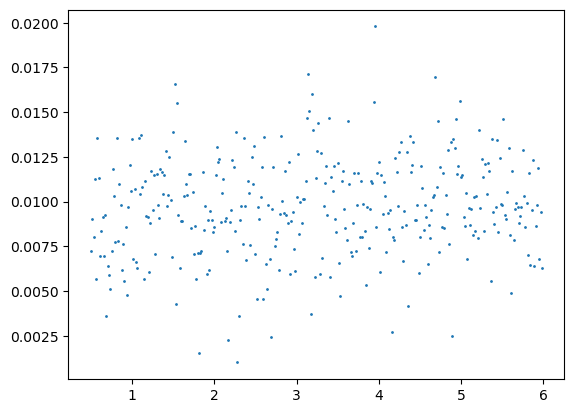

In [50]:
plt.scatter(chemical_shift[start:end], residuals3[start:end], s=1)
plt.show()

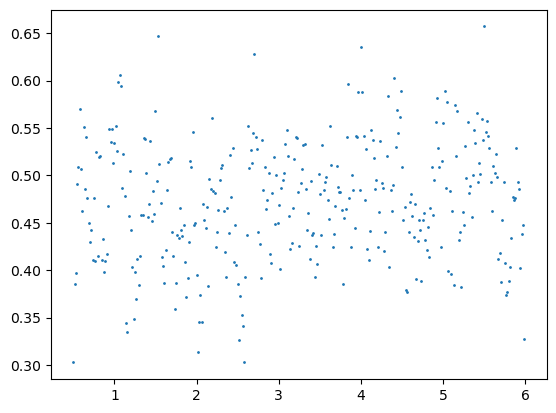

In [52]:
dist3 = np.average(comb_target, axis=0)

plt.scatter(chemical_shift[start:end], dist3[start:end], s=1)
plt.show()

In [107]:
import seaborn as sns
import pandas as pd

In [146]:
desired_width_pixels = 1000
desired_height_pixels = 1000
dpi = 96  # Adjust based on your needs

figure_width_inches = desired_width_pixels / dpi
figure_height_inches = desired_height_pixels / dpi

size = 20

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


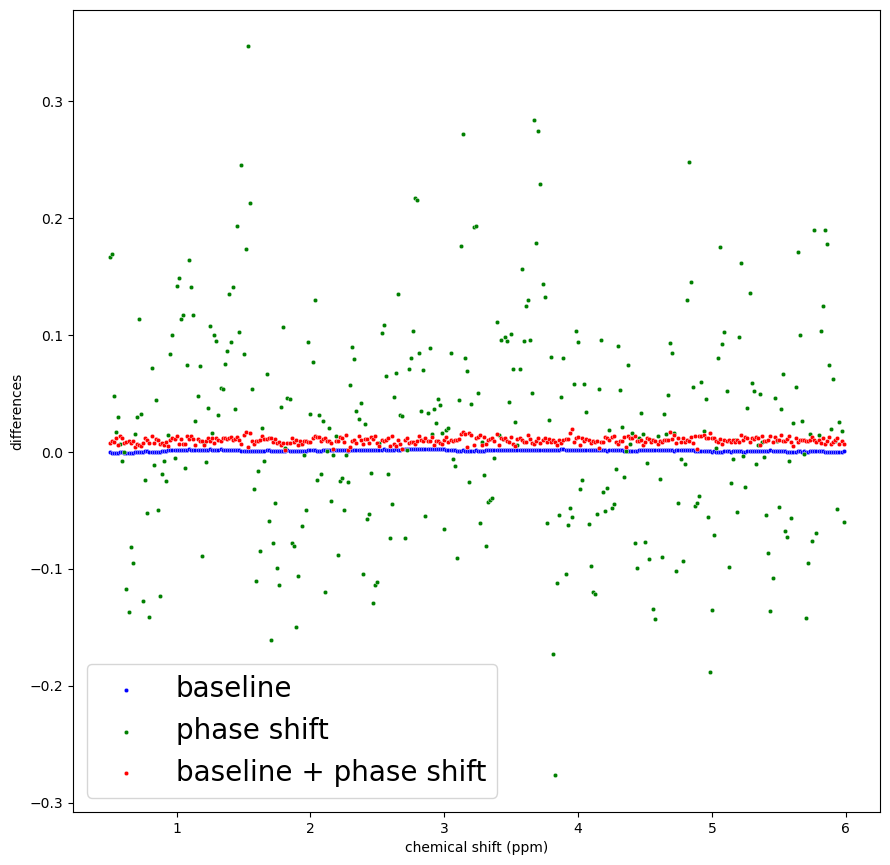

In [148]:
s = 10
# Creating DataFrames from the NumPy arrays
df1 = pd.DataFrame({'chemical shift (ppm)': chemical_shift[start:end], 'differences': residuals1[start:end]})
df2 = pd.DataFrame({'x': chemical_shift[start:end], 'y': residuals2[start:end]})
df3 = pd.DataFrame({'x': chemical_shift[start:end], 'y': residuals3[start:end]})

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# Plotting the first set of points with a label
sns.scatterplot(data=df1, x='chemical shift (ppm)', y='differences', color='blue', label='baseline', s=s)

# Plotting the second set of points with a label
sns.scatterplot(data=df2, x='x', y='y', color='green', label='phase shift', s=s)

# Plotting the third set of points with a label
sns.scatterplot(data=df3, x='x', y='y', color='red', label='baseline + phase shift', s=s)

# axes tick label size
#plt.tick_params(axis='chemical shift (ppm)', labelsize=size/2)
#plt.tick_params(axis='differences', labelsize=size/2)

# Add a legend
plt.legend(fontsize=size)

plt.savefig("residuals_all.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("residuals_all.eps", dpi=dpi)  # Save the plot with the same DPI

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


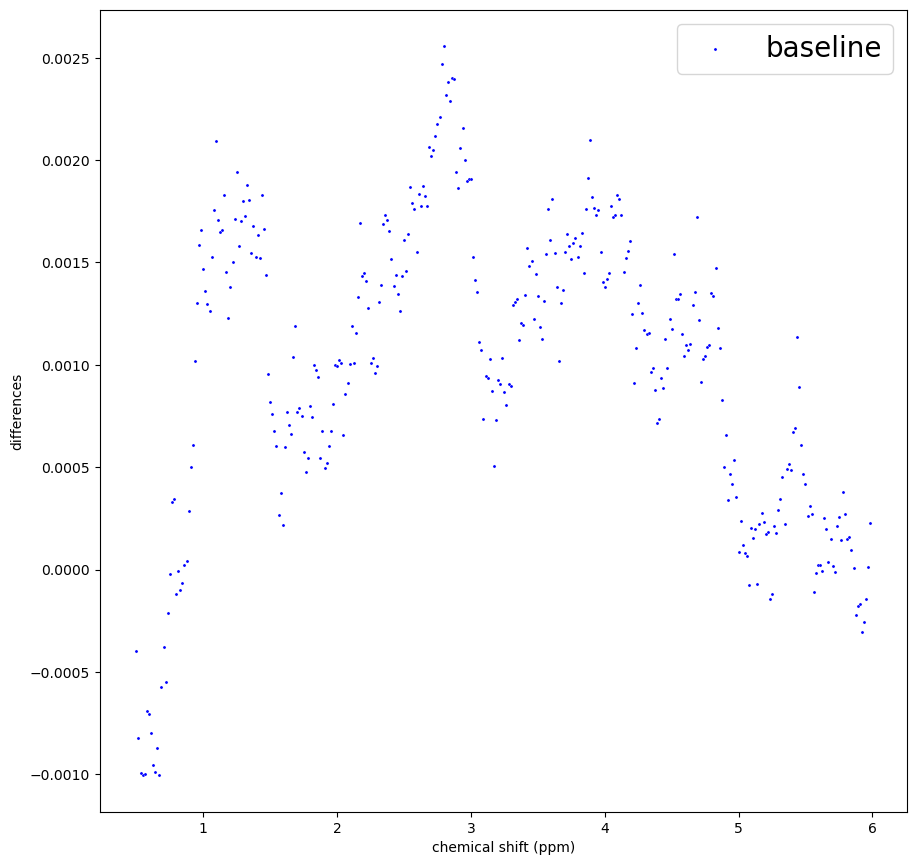

In [150]:
s = 10
# Creating DataFrames from the NumPy arrays
df1 = pd.DataFrame({'chemical shift (ppm)': chemical_shift[start:end], 'differences': residuals1[start:end]})

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# Plotting the first set of points with a label
sns.scatterplot(data=df1, x='chemical shift (ppm)', y='differences', color='blue', label='baseline', s=5)

# Add a legend
plt.legend(fontsize=size)

plt.savefig("residuals_baseline.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("residuals_baseline.eps", dpi=dpi)  # Save the plot with the same DPI

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


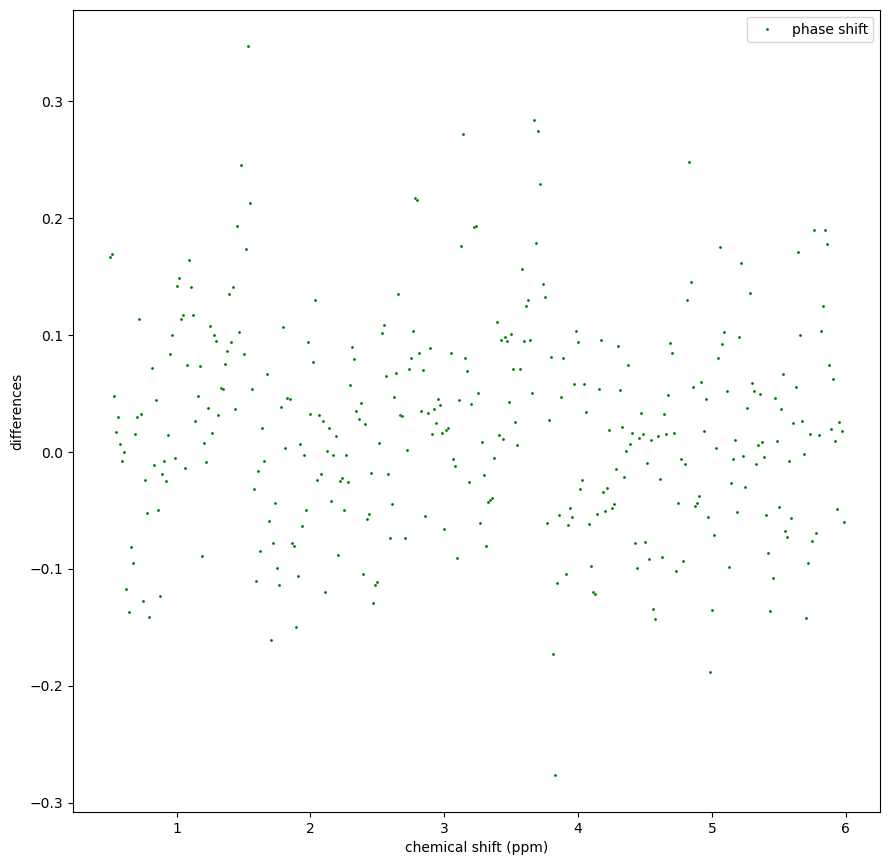

In [151]:
s = 10
# Creating DataFrames from the NumPy arrays
df2 = pd.DataFrame({'chemical shift (ppm)': chemical_shift[start:end], 'differences': residuals2[start:end]})

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# Plotting the first set of points with a label
sns.scatterplot(data=df2, x='chemical shift (ppm)', y='differences', color='green', label='phase shift', s=5)

# Adding the legend to the plot
plt.legend()

plt.savefig("residuals_phase.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("residuals_phase.eps", dpi=dpi)  # Save the plot with the same DPI

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


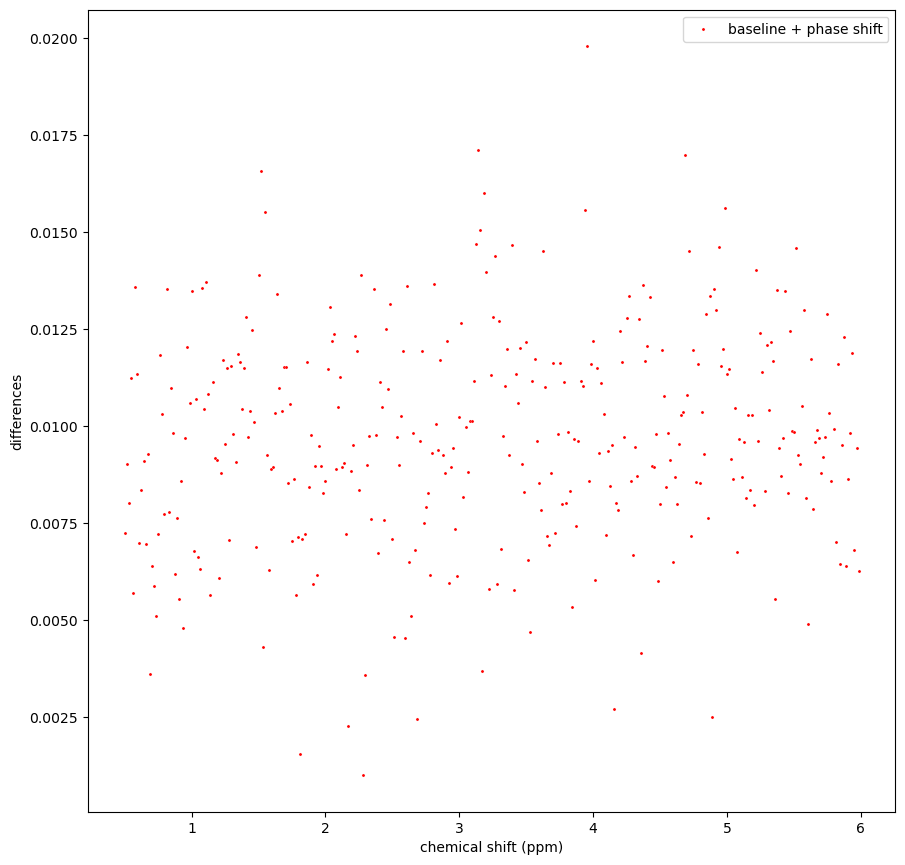

In [152]:
s = 10
# Creating DataFrames from the NumPy arrays
df3 = pd.DataFrame({'chemical shift (ppm)': chemical_shift[start:end], 'differences': residuals3[start:end]})

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# Plotting the first set of points with a label
sns.scatterplot(data=df3, x='chemical shift (ppm)', y='differences', color='red', label='baseline + phase shift', s=5)

# Adding the legend to the plot
plt.legend()

plt.savefig("residuals_PHB.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("residuals_PHB.eps", dpi=dpi)  # Save the plot with the same DPI

plt.show()

In [61]:
# data for figures
base_measure = base_input[1541]
base_true = base_target[1541]
base_pred = y_pred[1541]

phase_measure = phase_input[636]
phase_true = phase_target[636]
phase_pred = y_pred2[636]

comb_measure = comb_input[501]
comb_true = comb_target[501]
comb_pred = y_pred3[501]

In [65]:
figure_list = np.array([
    base_measure,
    base_true,
    base_pred,
    phase_measure,
    phase_true,
    phase_pred,
    comb_measure,
    comb_true,
    comb_pred]
)

figure_list.shape

(9, 1024)

In [81]:
with open('data_for_figures.npy', 'wb') as f:
    np.save(f, figure_list.astype('float32'))

## metric plots

In [76]:
baseline_losses = ['baseline_loss', 'baseline_mse', 'baseline_val_loss', 'baseline_val_mse']
losses_dict = {}
for loss in baseline_losses:
    losses_dict[loss] = np.load(loss + '.npy')

In [80]:
losses_dict.keys()

dict_keys(['baseline_loss', 'baseline_mse', 'baseline_val_loss', 'baseline_val_mse'])

In [96]:
model_losses = losses_dict['baseline_loss']
validation_losses = losses_dict['baseline_val_loss']
iterations = np.linspace(1, len(validation_losses), len(validation_losses))

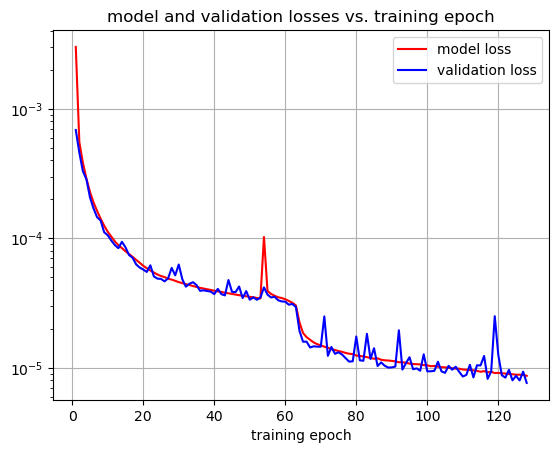

In [100]:
# loss plot
plt.plot(iterations, model_losses, label='model loss', color='red')

# validation loss plot
plt.plot(iterations, validation_losses, label='validation loss', color='blue')

# log scale
plt.yscale('log')

# Set the labels and title
plt.xlabel('training epoch')
plt.title('model and validation losses vs. training epoch')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [119]:
baseline2_losses = ['baseline2_loss', 'baseline2_mse', 'baseline2_val_loss', 'baseline2_val_mse']
losses_dict2 = {}
for loss in baseline2_losses:
    losses_dict2[loss] = np.load(loss + '.npy')

In [120]:
model_losses = np.concatenate(
    (losses_dict['baseline_loss'], losses_dict2['baseline2_loss']), 
    axis=None)

validation_losses = np.concatenate(
    (losses_dict['baseline_val_loss'], losses_dict2['baseline2_val_loss']), 
    axis=None)

iterations = np.linspace(1, len(validation_losses), len(validation_losses))

In [134]:
desired_width_pixels = 1200
desired_height_pixels = 800
dpi = 96  # Adjust based on your needs

figure_width_inches = desired_width_pixels / dpi
figure_height_inches = desired_height_pixels / dpi

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


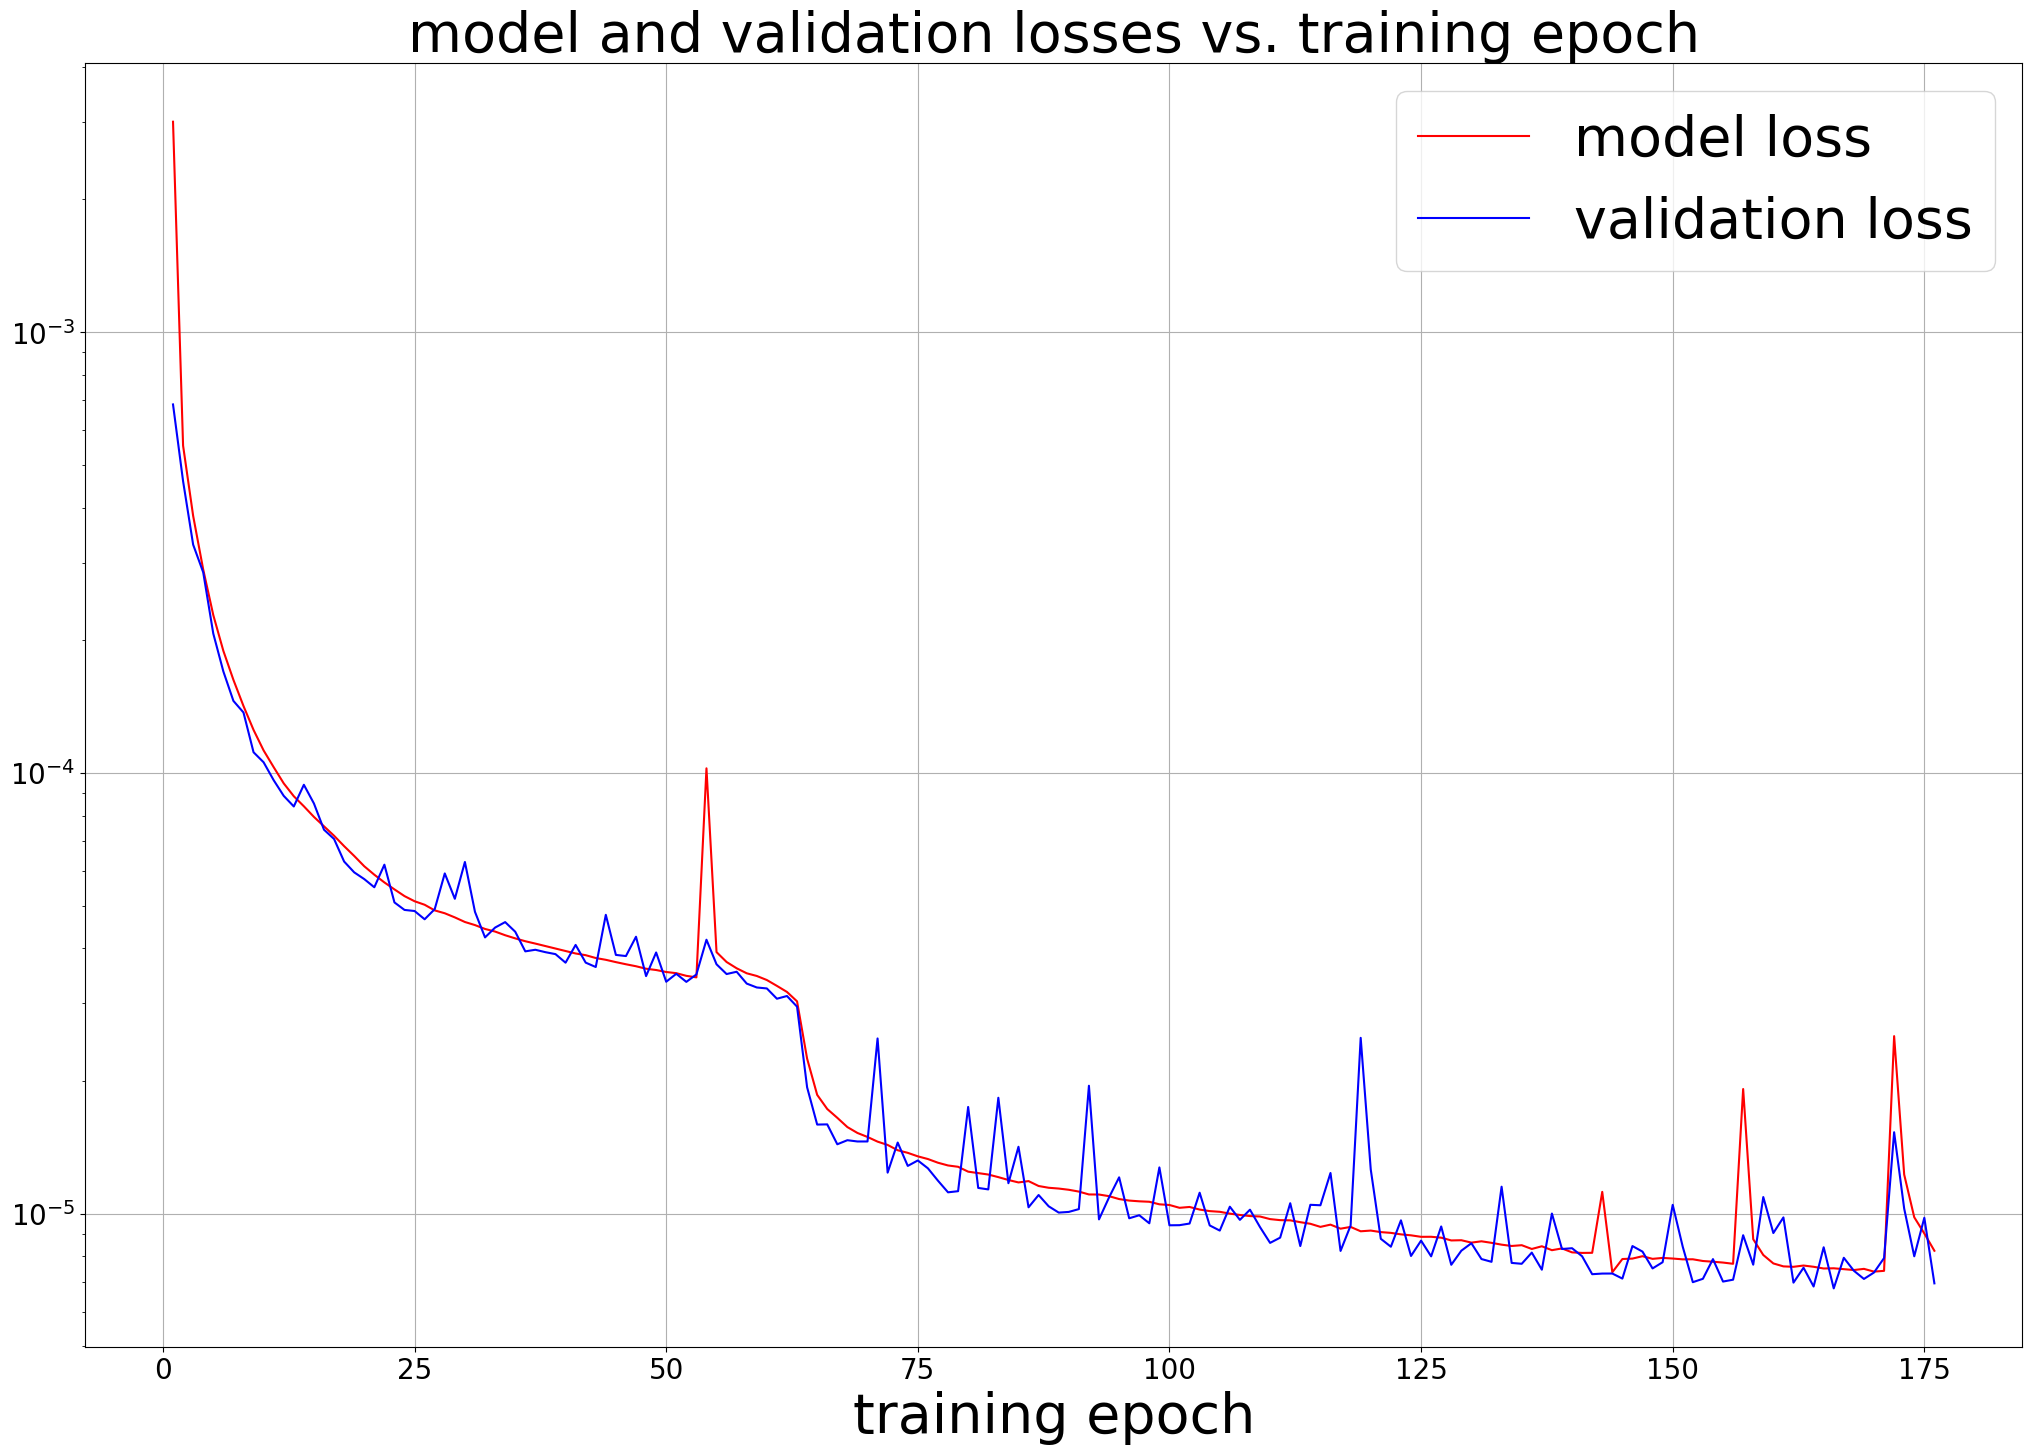

In [133]:
size = 40

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# loss plot
plt.plot(iterations, model_losses, label='training loss', color='red')

# validation loss plot
plt.plot(iterations, validation_losses, label='validation loss', color='blue')

# log scale
plt.yscale('log')

# Set the labels and title
plt.xlabel('training epoch', fontsize=size)
plt.title('training and validation losses vs. training epoch', fontsize=size)
plt.grid(True)

# axes tick label size
plt.tick_params(axis='x', labelsize=size/2)
plt.tick_params(axis='y', labelsize=size/2)

# Add a legend
plt.legend(fontsize=size)

plt.savefig("losses_track.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("losses_track.eps", dpi=dpi)  # Save the plot with the same DPI

# Show the plot
plt.show()

## comparison plots

In [ ]:
size = 40

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# loss plot
plt.plot(iterations, model_losses, label='model loss', color='red')

# validation loss plot
plt.plot(iterations, validation_losses, label='validation loss', color='blue')

# log scale
plt.yscale('log')

# Set the labels and title
plt.xlabel('training epoch', fontsize=size)
plt.title('model and validation losses vs. training epoch', fontsize=size)
plt.grid(True)

# axes tick label size
plt.tick_params(axis='x', labelsize=size/2)
plt.tick_params(axis='y', labelsize=size/2)

# Add a legend
plt.legend(fontsize=size)

plt.savefig("losses_track.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("losses_track.eps", dpi=dpi)  # Save the plot with the same DPI

# Show the plot
plt.show()

In [198]:
desired_width_pixels = 1200
desired_height_pixels = 450
dpi = 96  # Adjust based on your needs

figure_width_inches = desired_width_pixels / dpi
figure_height_inches = desired_height_pixels / dpi

In [153]:
range_path = Path.home() / Path('gd/projects/projnmr/scripts/chemical_shift.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]
    
chemical_shift

array([0.0000000e+00, 1.5625000e-02, 3.1250000e-02, ..., 1.5953125e+01,
       1.5968750e+01, 1.5984375e+01], dtype=float32)

<Figure size 1250x468.75 with 0 Axes>

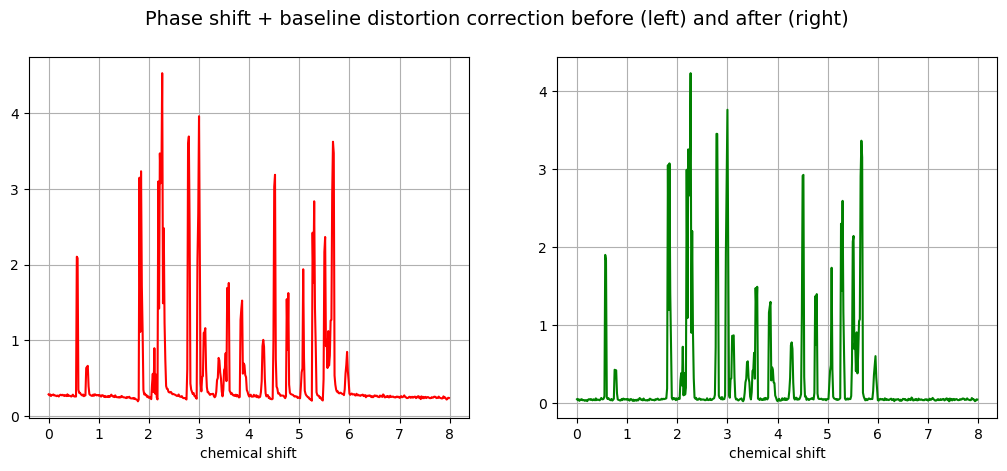

In [226]:
# chemical shift and figure size
cutoff = int(1024/2)
ch = chemical_shift[:cutoff]
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# pick n = 0, 1, or 2 (baseline, pahse+shift, both)
n = 2
s1 = example_figures[3*n + 0][:cutoff] # measured
s2 = example_figures[3*n + 1][:cutoff] # true
s3 = example_figures[3*n + 2][:cutoff] # predicted

fig, axs = plt.subplots(1, 2, figsize=(figure_width_inches, figure_height_inches))
axs[0].plot(ch, s1, color='red')
axs[0].set_xlabel('chemical shift')

axs[1].plot(ch, s2, color='green')
axs[1].set_xlabel('chemical shift')

# title
# fig.suptitle("Baseline distortion correction before (left) and after (right)", fontsize=14, horizontalalignment='center')
# fig.suptitle("Phase shift distortion correction before (left) and after (right)", fontsize=14, horizontalalignment='center')
fig.suptitle("Phase shift + baseline distortion correction before (left) and after (right)", fontsize=14, horizontalalignment='center')

# figure grid
axs[0].grid(True)
axs[1].grid(True)

# save figures
plt.savefig("both_comparison.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("both_comparison.eps", dpi=dpi)  # Save the plot with the same DPI
plt.show()

## residuial plot

In [12]:
data_path = Path.home() / Path('data/NMR.SH8.data/data.1390177')
dataset = ftnmr.load_spec_data(data_path, batch_size=128)

In [13]:
model_path = Path.home() / Path('gd/projects/projnmr/scripts/model_PHB_AIL.mar.01.2024.hdf5')
model_path = str(model_path)
loaded_model_PHB = keras.models.load_model(model_path, compile=False)

In [14]:
test_dataset = next(iter(dataset[2]))
sample = test_dataset[0]
dims = sample.shape
dims

TensorShape([128, 32768])

In [15]:
predicted = loaded_model_PHB(test_dataset[0])

In [16]:
X = test_dataset[0].numpy()
y_pred = predicted.numpy()
y_target = test_dataset[1].numpy()

In [17]:
shift_path = Path.home() / Path('data/NMR.SH8.data/chemical_shift.1390177.hdf5')
shift = ftnmr.load_shift(shift_path)
shift

array([0.0000000e+00, 4.8828125e-04, 9.7656250e-04, ..., 1.5998535e+01,
       1.5999023e+01, 1.5999512e+01], dtype=float32)

In [35]:
shift = shift/2

In [71]:
ind = np.random.choice(range(len(y_pred)))
x_t = X[ind]
y_true = y_target[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(shift, Y, Y_names=Y_names)

21


Output()

In [72]:
#ind: 21
#x: 3.5 to 6.0
#y: -0.2 to 1.2

In [24]:
valid_set = dataset[1]
test_set = dataset[2]

In [25]:
def disc_sq_sums(TFdata, total_num, residuals):
    predicted = loaded_model_PHB(TFdata[0]).numpy()
    target = TFdata[1].numpy()
    total_num += target.shape[0]
    disc_sq = (predicted - target)**2
    residuals += np.sum(disc_sq, axis=0)
    return residuals, total_num

In [26]:
total_num = 0
residuals = np.zeros((32768,))

for data in valid_set:
    residuals, total_num = disc_sq_sums(data, total_num, residuals)
    
for data in test_set:
    residuals, total_num = disc_sq_sums(data, total_num, residuals)

In [28]:
residuals.shape

(32768,)

In [29]:
total_num

4096

In [54]:
residues = np.sqrt(residuals/total_num)

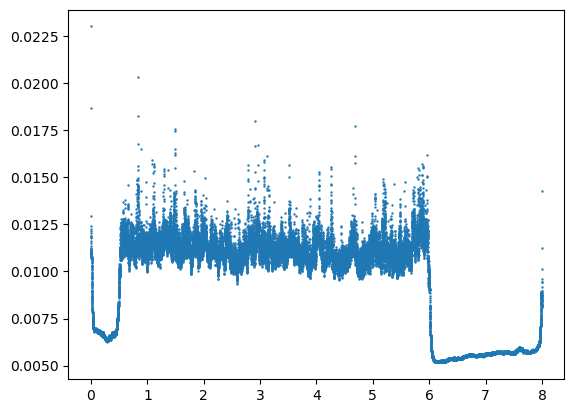

In [55]:
plt.scatter(shift, residues, s=0.5)
plt.show()

In [53]:
seg = int(shift.shape[0]/16)
seg # 0.5 ppm

2048

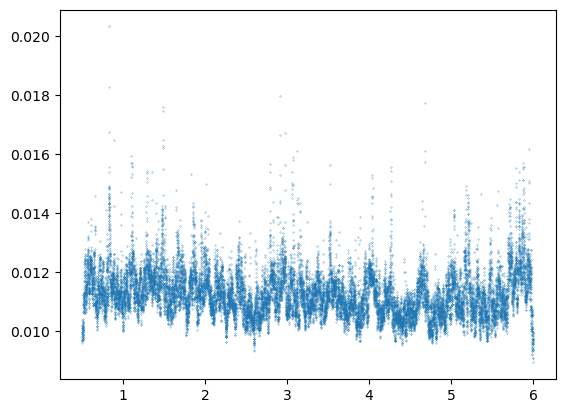

In [59]:
plt.scatter(shift[seg:12*seg], residues[seg:12*seg], s=0.05)
plt.show()

In [60]:
desired_width_pixels = 1200
desired_height_pixels = 800
dpi = 96  # Adjust based on your needs

figure_width_inches = desired_width_pixels / dpi
figure_height_inches = desired_height_pixels / dpi

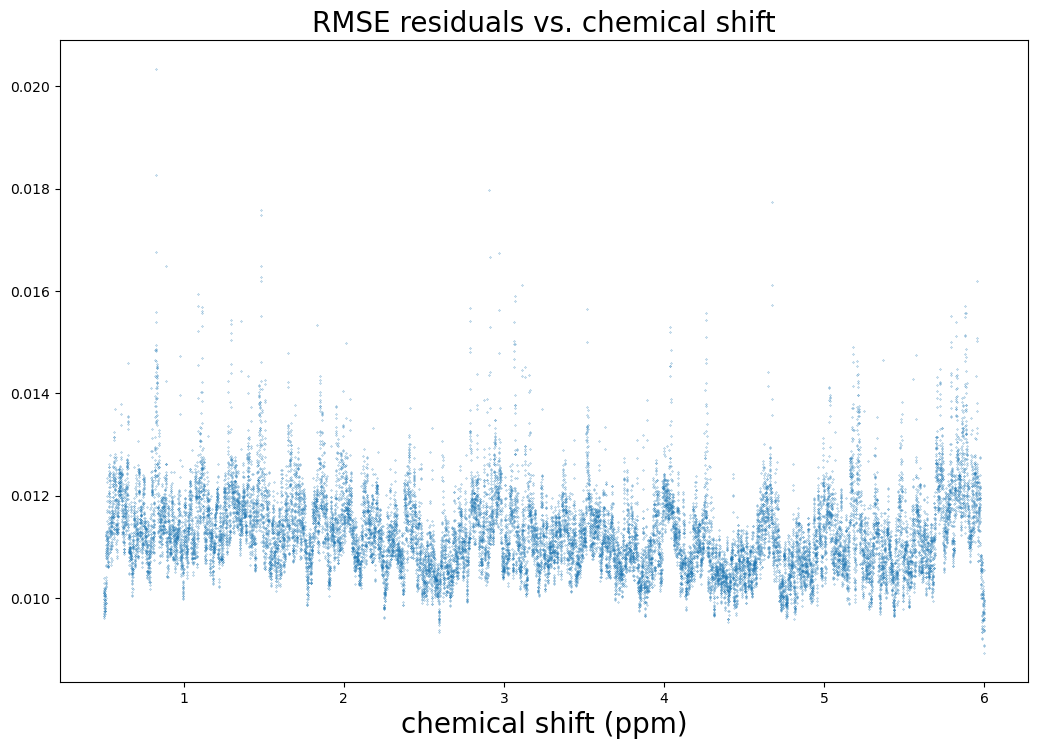

In [62]:
size = 20

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# residual plots
plt.scatter(shift[seg:12*seg], residues[seg:12*seg], s=0.05)

# Set the labels and title
plt.xlabel('chemical shift (ppm)', fontsize=size)
plt.title('RMSE residuals vs. chemical shift', fontsize=size)

# axes tick label size
plt.tick_params(axis='x', labelsize=size/2)
plt.tick_params(axis='y', labelsize=size/2)

plt.savefig("residuals.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("residuals.eps", dpi=dpi)  # Save the plot with the same DPI

# Show the plot
plt.show()

In [73]:
#ind: 21
#x: 3.5 to 6.0
#y: -0.2 to 1.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


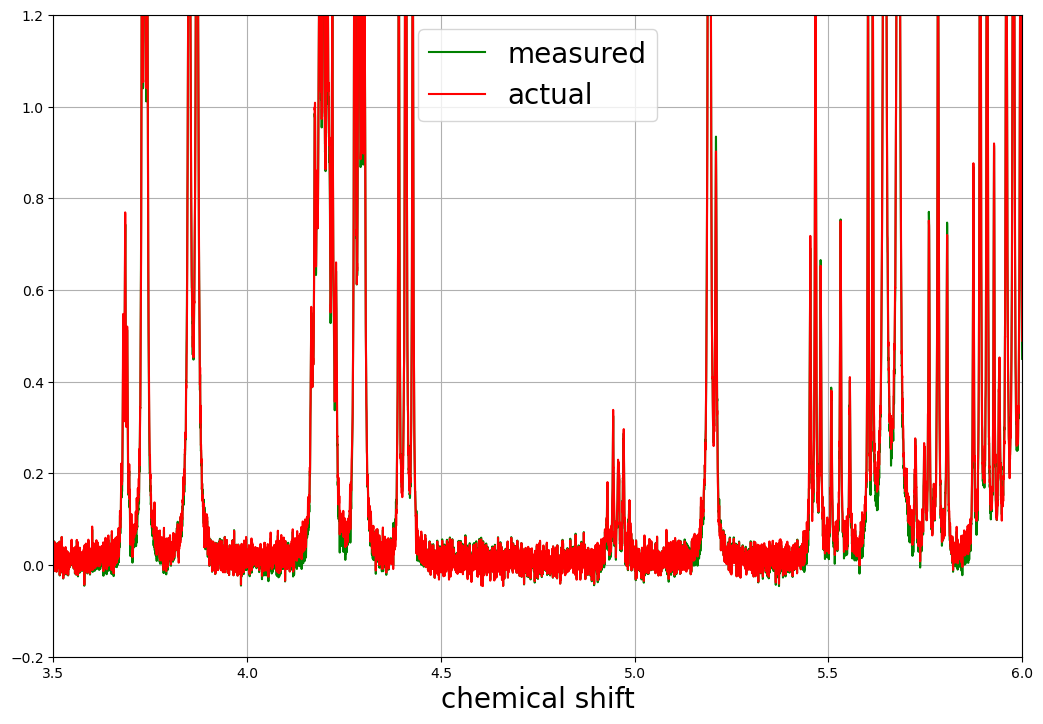

In [80]:
ind = 21
x_t = X[ind]
y_true = y_target[ind]
y_p = y_pred[ind]

size = 20

# figure size
plt.figure(figsize=(figure_width_inches, figure_height_inches))

# first plot
plt.plot(shift[7*seg:12*seg], y_true[7*seg:12*seg], label='measured', color='green')

# second plot
plt.plot(shift[7*seg:12*seg], y_p[7*seg:12*seg], label='actual', color='red')

# x, y-axis limit 
plt.ylim(-0.2, 1.2)
plt.xlim(3.5, 6.0)

# Set the labels and title
plt.xlabel('chemical shift', fontsize=size)
# plt.title('NMR spectrum both measured and actual', fontsize=size)
plt.grid(True)

# axes tick label size
plt.tick_params(axis='x', labelsize=size/2)
plt.tick_params(axis='y', labelsize=size/2)

# Add a legend
plt.legend(fontsize=size)

plt.savefig("actual_predicted.png", dpi=dpi)  # Save the plot with the same DPI
plt.savefig("actual_predicted.eps", dpi=dpi)  # Save the plot with the same DPI

# Show the plot
plt.show()